# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing and learned patterns for our own problems

In [1]:
# Are we using a GPU
!nvidia-smi

Tue Jan 24 11:28:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

## Download and becoming one with the data

In [2]:
# Get data (10% of 10 food classes from Food101)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-01-24 11:28:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.128, 74.125.31.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   179MB/s    in 0.9s    

2023-01-24 11:28:54 (179 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import zipfile

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [4]:
# How many images in each folder
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} image in '{dirpath}'")

There are 2 directories and 0 image in '10_food_classes_10_percent'
There are 10 directories and 0 image in '10_food_classes_10_percent/train'
There are 0 directories and 75 image in '10_food_classes_10_percent/train/ice_cream'
There are 0 directories and 75 image in '10_food_classes_10_percent/train/pizza'
There are 0 directories and 75 image in '10_food_classes_10_percent/train/hamburger'
There are 0 directories and 75 image in '10_food_classes_10_percent/train/chicken_curry'
There are 0 directories and 75 image in '10_food_classes_10_percent/train/chicken_wings'
There are 0 directories and 75 image in '10_food_classes_10_percent/train/sushi'
There are 0 directories and 75 image in '10_food_classes_10_percent/train/steak'
There are 0 directories and 75 image in '10_food_classes_10_percent/train/ramen'
There are 0 directories and 75 image in '10_food_classes_10_percent/train/fried_rice'
There are 0 directories and 75 image in '10_food_classes_10_percent/train/grilled_salmon'
There are

## Creating data loaders (preparing the data)

In [5]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Images: ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing Images: ")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical")

Training Images: 
Found 750 images belonging to 10 classes.
Testing Images: 
Found 2500 images belonging to 10 classes.


### Setting up callbacks (thing to run while our model trains)

some of the most popular:
1. Tracking experiment with the tensorboard callback
2. Model chckpoint with the ModelCheckpoint
3. Stopping a model from training (before it trains too long)

In [6]:
# Create TensorBoard callback
import tensorflow as tf
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to {log_dir}")
    return tensorboard_callback

## Creating models using TensorFlow Hub

In [7]:
# Let's compare the following two models
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

In [8]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [9]:
# Make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
    """
    Takes a TensorFlow Hub URL and creates a Keras Sequential
    
    Args:
        model_url (str): A TensorFlow Hub feature extraction URL
        num_classes (int): Number of output neurons in the output layer, should be equal to number of target classes, default 10.
         
         
    Returns:
        An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons
    """
    # Download the pretrained model
    feature_extractor_layer = hub.KerasLayer(model_url, 
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,)) # (224, 224, 3)
    
    # Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation="softmax", name="output_layer")
    ])
    
    return model

### Creating and testing ResNet TensorFlow Hub Feature extraction model

In [10]:
# Create resnet model
resnet_model = create_model(resnet_url)

2023-01-24 11:29:04.408581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 11:29:04.409526: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 11:29:04.564896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 11:29:04.565830: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 11:29:04.566681: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [11]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])

# Fit the data
history_resnet = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  callbacks=create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name="resnet50v2"))

2023-01-24 11:29:10.138835: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-24 11:29:10.138885: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-01-24 11:29:10.141300: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 2 GPUs
2023-01-24 11:29:10.568819: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-24 11:29:10.569021: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Saving TensorBoard log files to tensorflow_hub/resnet50v2/20230124-112910


2023-01-24 11:29:10.937253: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2023-01-24 11:29:15.792011: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1/24 [>.............................] - ETA: 4:45 - loss: 2.7769 - accuracy: 0.1250

2023-01-24 11:29:23.700993: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-24 11:29:23.701058: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/24 [=>............................] - ETA: 27s - loss: 2.7027 - accuracy: 0.0938 

2023-01-24 11:29:24.622571: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-01-24 11:29:24.623770: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-01-24 11:29:24.788849: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 337 callback api events and 334 activity events. 
2023-01-24 11:29:24.805133: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 3/24 [==>...........................] - ETA: 16s - loss: 2.6387 - accuracy: 0.1250

2023-01-24 11:29:24.829735: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tensorflow_hub/resnet50v2/20230124-112910/train/plugins/profile/2023_01_24_11_29_24

2023-01-24 11:29:24.837942: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to tensorflow_hub/resnet50v2/20230124-112910/train/plugins/profile/2023_01_24_11_29_24/f0acc58d7ef7.trace.json.gz
2023-01-24 11:29:24.878975: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tensorflow_hub/resnet50v2/20230124-112910/train/plugins/profile/2023_01_24_11_29_24

2023-01-24 11:29:24.887794: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to tensorflow_hub/resnet50v2/20230124-112910/train/plugins/profile/2023_01_24_11_29_24/f0acc58d7ef7.memory_profile.json.gz
2023-01-24 11:29:24.889010: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: 

24/24 [==============================] - 33s 880ms/step - loss: 1.8974 - accuracy: 0.3800 - val_loss: 1.1538 - val_accuracy: 0.6444
Epoch 2/5
24/24 [==============================] - 18s 754ms/step - loss: 0.8960 - accuracy: 0.7293 - val_loss: 0.8486 - val_accuracy: 0.7300
Epoch 3/5
24/24 [==============================] - 25s 1s/step - loss: 0.6320 - accuracy: 0.8093 - val_loss: 0.7437 - val_accuracy: 0.7688
Epoch 4/5
24/24 [==============================] - 18s 785ms/step - loss: 0.4926 - accuracy: 0.8587 - val_loss: 0.6752 - val_accuracy: 0.7860
Epoch 5/5
24/24 [==============================] - 17s 735ms/step - loss: 0.3865 - accuracy: 0.9013 - val_loss: 0.6588 - val_accuracy: 0.7852


In [12]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [13]:
import matplotlib.pyplot as plt

# Plot the validation and training curves separately
def plot_loss_curves(history):
  """
  Returns separates loss curves for training and validation metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.figure(figsize=(10,7))
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure(figsize=(10,7))
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

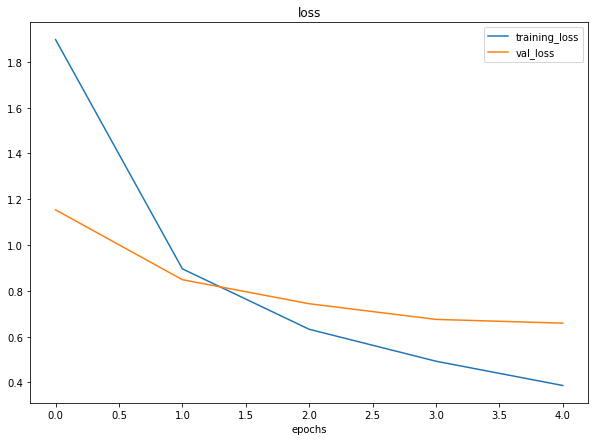

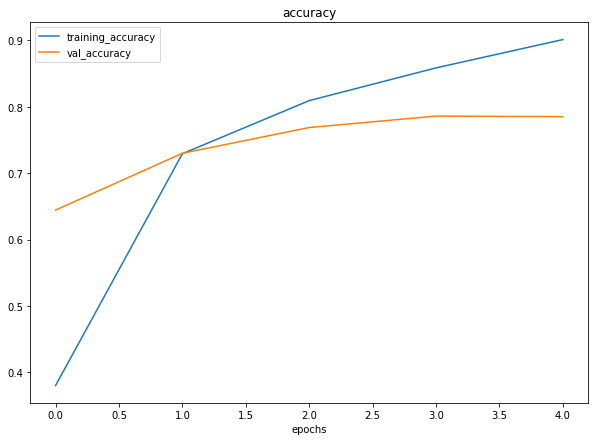

In [14]:
plot_loss_curves(history_resnet)